In [1]:
## Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
import seaborn as sns
import re
import numpy as np

In [2]:
df_climbs_angles = pd.read_csv('data/csvs/climbs_with_angles.csv', low_memory=False)
df_climbs = pd.read_csv('data/csvs/climbs.csv')
df_holes = pd.read_csv('data/csvs/holes.csv')
df_colors = pd.read_csv('data/csvs/placement_roles.csv')
df_vscale = pd.read_csv('data/csvs/vscale.csv')


In [3]:
def extract_hold_data(frame_str):
    color_strings = re.findall(r'\d+', frame_str)
    return [int(color_str) for color_str in color_strings]


def get_coordinates(id_list, df_holes):
    coordinates = []
    for id_val in id_list:
        coords = df_holes[df_holes['id'] == id_val][['x', 'y']].values.tolist()
        coordinates.extend(coords)
    return coordinates

def color_mapping(index):
    color = df_colors.loc[df_colors.id == index].screen_color.values
    if color: return f"#{color[0]}"
    else: return f"error index"

In [4]:
df_climbs['ids'] = df_climbs['frames'].apply(lambda x: extract_hold_data(x)[0::2])
df_climbs['colors'] = df_climbs['frames'].apply(lambda x: extract_hold_data(x)[1::2])
df_climbs['coordinates'] = df_climbs['ids'].apply(lambda x: get_coordinates(x, df_holes))

In [5]:
def plot_climb_by_id(id=1):   
    hold_pos = np.asarray(df_climbs['coordinates'][id])
    color_ids = df_climbs['colors'][id] 
    colors = [color_mapping(color_id) for color_id in color_ids]
    x_limits = [0, 144]
    y_limits = [0, 156]
    plt.gca().add_patch(Rectangle((x_limits[0], y_limits[0]), x_limits[1]-x_limits[0], y_limits[1]-y_limits[0], facecolor='grey', zorder=0))
    img1 = mpimg.imread('data/pngs/kilter_large_holds.png')  
    plt.imshow(img1, extent=[x_limits[0], x_limits[1], y_limits[0], y_limits[1]], zorder=1)  
    img2 = mpimg.imread('data/pngs/kilter_small_holds.png')  # Replace with your actual file path
    plt.imshow(img2, extent=[x_limits[0], x_limits[1], y_limits[0], y_limits[1]], aspect='auto', alpha=1, zorder=2)  
    
    x = hold_pos[:, 0]
    y = hold_pos[:, 1]  
    plt.scatter(x, y, facecolors='none', edgecolors=colors, s=100, linewidth=1.5, zorder=3)
    plt.axis('off')
    plt.xlim(x_limits)
    plt.ylim(y_limits)
    plt.gca().set_title(df_climbs['name'][id], fontsize=18)
    
    plt.show()

In [63]:
def plot_stats(id=1):
    subset_df = df_climbs_angles.loc[df_climbs_angles['uuid'] == df_climbs['uuid'][id]]
    subset_df = subset_df.sort_values(by='angle')
    subset_df['display_difficulty'] = subset_df['display_difficulty'].astype(int)
    df_vscale['difficulty'] = df_vscale['difficulty'].astype(int)
    subset_df = pd.merge(subset_df, df_vscale, 
                         left_on='display_difficulty', right_on='difficulty', 
                         how='left')
    sns.set_style("whitegrid")
    sns.set_context("talk")  
    subset_df['boulder_name'] = pd.Categorical(subset_df['boulder_name'], 
                                               categories=df_vscale['boulder_name'], 
                                               ordered=True)
    subset_df = subset_df.sort_values('boulder_name')

    boulder_names_present = subset_df['boulder_name'].unique()
    custom_palette = sns.color_palette("viridis", n_colors=len(boulder_names_present))
    color_mapping = dict(zip(boulder_names_present, custom_palette))
    # Create the plot
    fig, ax = plt.subplots(figsize=(7, 4))
    sns.scatterplot(data=subset_df, 
                    x='angle', 
                    y='ascensionist_count', 
                    hue="boulder_name",
                    palette=color_mapping,
                    hue_order=boulder_names_present,  # Use boulder names from subset_df
                    s=100,  
                    edgecolor='white', 
                    linewidth=0.5, 
                    ax=ax)

    sns.lineplot(data=subset_df, x='angle', y='ascensionist_count', color='gray', linestyle='dashed', ax=ax)
    ax.set_title('Ascensionist Count vs. Angle', fontsize=18, pad=10)
    ax.set_xlabel('Angle', fontsize=16)
    ax.set_ylabel('Ascensionist Count', fontsize=16)
    legend = ax.legend(title='Difficulty', bbox_to_anchor=(1, 1.2), loc='upper left', frameon=False)
    plt.setp(legend.get_title(), fontsize=14)  
    plt.setp(legend.get_texts(), fontsize=12)  
    plt.tight_layout()
    plt.show()


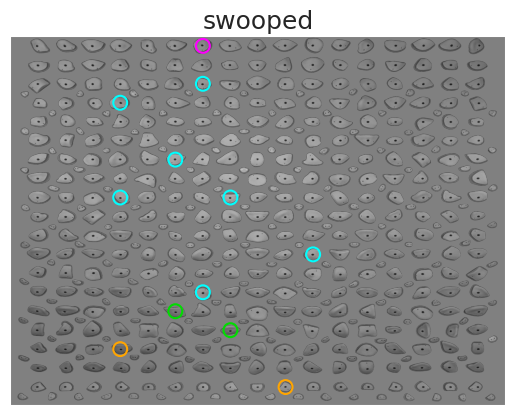

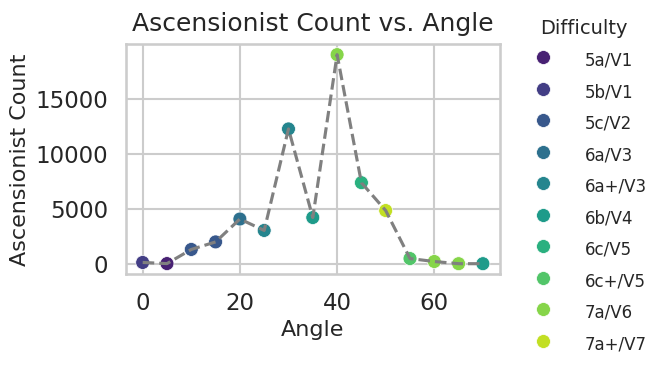

In [64]:
id = 1
plot_climb_by_id(id)
plot_stats(id)